# Analyze Top Hat Jet properties

In [2]:
import copy
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm, Normalize
from IPython.display import clear_output
# settings
# plt.style.use("fivethirtyeight")

try:
    import PyBlastAfterglowMag as PBA
except:
    raise ImportError("Cannot import PyBlastAfterglowMag")
try:
    import afterglowpy as grb
except:
    afterglowpy = False
    print("Error! could not import afteglowpy")

from grbafg.tools import *
from settings import SettingsTopHat

curdir = os.getcwd() + '/'

figs = os.getcwd()+"/figs/"
out = os.getcwd()+"/out/"
pdfs = "/home/vsevolod/Work/GIT/overleaf/grb_model_paper/figs/"

# GRP parameters

In [3]:
df_structure = pd.DataFrame.from_dict(SettingsTopHat.structure,orient='index').T
df_structure["Eiso_c"] = df_structure["Eiso_c"].astype(float)
df_pars = pd.DataFrame.from_dict(SettingsTopHat.pars)
display(df_structure.head())
display(df_pars.head())

struct        Eiso_c Gamma0c  M0c theta_c theta_w nlayers_pw nlayers_a
0  tophat  1.000000e+53  1000.0 -1.0     0.1     0.1        150         1

skymap_times      obs_freq  n_ism  eps_e_fs           d_l  eps_b_fs      z  \
0           1.0  3.000000e+09   10.0       0.1  3.090000e+26      0.01  0.028   
1          10.0  3.000000e+09   10.0       0.1  3.090000e+26      0.01  0.028   
2          40.0  3.000000e+09   10.0       0.1  3.090000e+26      0.01  0.028   
3         100.0  3.000000e+09   10.0       0.1  3.090000e+26      0.01  0.028   
4         200.0  3.000000e+09   10.0       0.1  3.090000e+26      0.01  0.028   

   p_fs  theta_obs  nsublayers  
0   2.2       1.57           1  
1   2.2       1.57           1  
2   2.2       1.57           1  
3   2.2       1.57           1  
4   2.2       1.57           1

# Run the Model

In [4]:
cases = CasesFS(default_parfile_fpath=curdir+"parfile_def.par", workingdir=curdir+"output/")
tsk = SettingsTopHat()

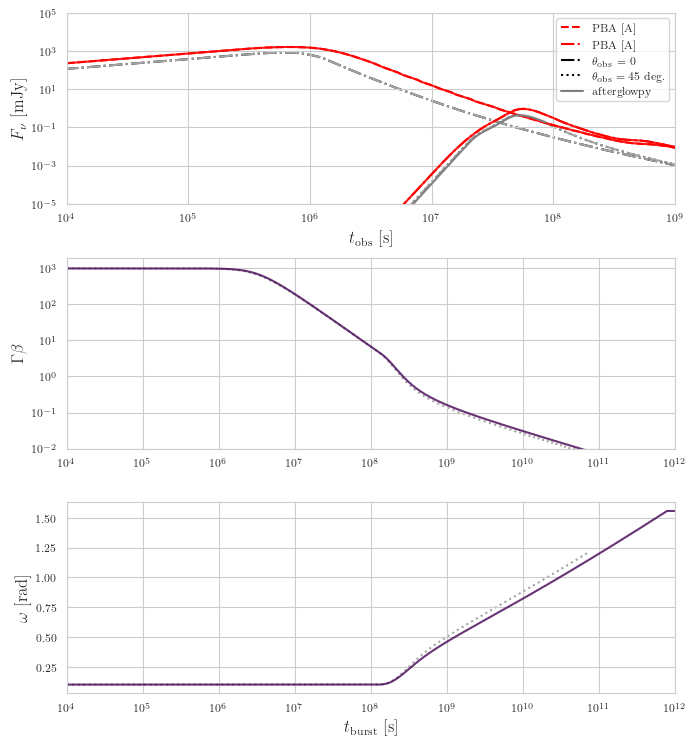

In [5]:
# Plot Spreading against afterglowpy (with n_ism=1.)
def plot_generic():
    
    struct=copy.deepcopy(tsk.structure)
    pars=copy.deepcopy(tsk.pars)
    opts_a=copy.deepcopy(tsk.opts_a)

    pars["n_ism"] = 0.01

    
    fig, axes = plt.subplots(figsize=(7,7.5), ncols=1, nrows=3)
    # run the code for given pars
    pars["theta_obs"] = 0
    pba_a = cases.run_a(struct=struct, pars=pars, opts={}, opts_grb=opts_a); clear_output(wait=False)
    cases.plot_lcs(ax=axes[0], pars=pars, pba=pba_a, layers = (),
                      plot={"ls":'--', "color":"red", "label":"PBA [A]"},plot_layer={})

    pars["theta_obs"] = 0.785
    pba_a = cases.run_a(struct=struct, pars=pars, opts={}, opts_grb=opts_a); clear_output(wait=False)
    cases.plot_lcs(ax=axes[0], pars=pars, pba=pba_a, layers = (),
                   plot={"ls":'-.', "color":"red", "label":"PBA [A]"},plot_layer={})

    ref = RefData(workdir=cases.workingdir, fname="reference_afgpy_dyn.h5")#"reference_afgpy_dyn.h5")
    ref_lc2 = RefDataLC(workdir=cases.workingdir, fname="reference_lc_0785deg_layer.h5")#"reference_lc_0deg_layer.h5")
    ref_lc = RefDataLC(workdir=cases.workingdir, fname="reference_lc_0deg_layer.h5")#"reference_lc_0deg_layer.h5")
    
    cases.plot_lcs_ref(ax=axes[0], ref=ref_lc, ls='-.', 
                       label=r"$\theta_{\rm obs}$ = 0", 
                       nlayers=pba_a.GRB.get_lc_obj().attrs["nlayers"])
    cases.plot_lcs_ref(ax=axes[0], ref=ref_lc2, ls=':', 
                       label=r"$\theta_{\rm obs} = 45$ deg.", 
                       nlayers=pba_a.GRB.get_lc_obj().attrs["nlayers"])
    
    cases.plot_dyn(axes[1], pba=pba_a, v_n_x="tburst", v_n_y="mom", 
                   layers=(), plot_layer={"ls":'-', "cmap":"viridis", "alpha":.8})
    cases.plot_dyn_ref(axes[1], ref=ref, v_n_x="tburst", v_n_y="mom", 
                       nlayers=pba_a.GRB.get_dyn_obj().attrs["nlayers"])
    
    cases.plot_dyn(axes[2], pba=pba_a, v_n_x="tburst", v_n_y="theta", 
                   layers=(), plot_layer={"ls":'-', "cmap":"viridis", "alpha":.8})
    cases.plot_dyn_ref(axes[2], ref=ref, v_n_x="tburst", v_n_y="theta", 
                       nlayers=pba_a.GRB.get_dyn_obj().attrs["nlayers"])


    # -------- Afterglopy --------------
    Z = {'jetType':     grb.jet.TopHat if struct["struct"] == "tophat" else grb.jet.Gaussian,     # Top-Hat jet
         'specType':    0,                  # Basic Synchrotron Spectrum
         'counterjet':  1,
         'spread':      7,
         'thetaObs':    pars["theta_obs"],   # Viewing angle in radians
         'E0':          struct["Eiso_c"], # Isotropic-equivalent energy in erg
         'g0':          struct["Gamma0c"],
         'thetaCore':   struct["theta_c"],    # Half-opening angle in radians
         'thetaWing':   struct["theta_w"],
         'n0':          pars["n_ism"],    # circumburst density in cm^{-3}
         'p':           pars["p_fs"],    # electron energy distribution index
         'epsilon_e':   pars["eps_e_fs"],    # epsilon_e
         'epsilon_B':   pars["eps_b_fs"],   # epsilon_B
         'xi_N':        1.0,    # Fraction of electrons accelerated
         'd_L':         pars["d_l"], # Luminosity distance in cm
         'z':           pars["z"]}   # redshift

    t = np.geomspace(1.0 * 86400.0, 1.0e3 * 86400.0, 100)
    nu = np.empty(t.shape)
    nu[:] = pars["obs_freq"]
    Fnu = grb.fluxDensity(t, nu, **Z)
    # plot
    ax = axes[0]
    ax.plot(t, Fnu, ls='-', color='gray', label='afterglowpy')

    
    # adjust
    ax = axes[0]

    # ax.grid()
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(r"$F_{\nu}$ [mJy]", fontsize=12)
    ax.set_title(None)
    ax.set_xlim(1e4,1e9)
    ax.set_ylim(1e-5,1e5)
    ax.set_xlabel(r"$t_{\rm obs}$ [s]", fontsize=12)
    # ax.grid()

    ax = axes[1]
    # ax.grid()
    ax.set_ylabel(r"$\Gamma\beta$", fontsize=12)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e4,1e12)
    ax.set_ylim(1e-2,2e3)

    ax = axes[2]
    # ax.grid()
    # ax.legend()
    ax.set_ylabel(r"$\omega$ [rad]", fontsize=12)
    ax.set_xscale("log")
    ax.set_yscale("linear")
    ax.set_xlabel(r"$t_{\rm burst}$ [s]", fontsize=12)
    ax.set_xlim(1e4,1e12)
    plt.tight_layout()
    
    figname = "abstract_tophat_ref_lcs_dyn"
    plt.savefig(pdfs+figname+".pdf")
    plt.savefig(pdfs+figname+".png", dpi=256)
    plt.show()
plot_generic()

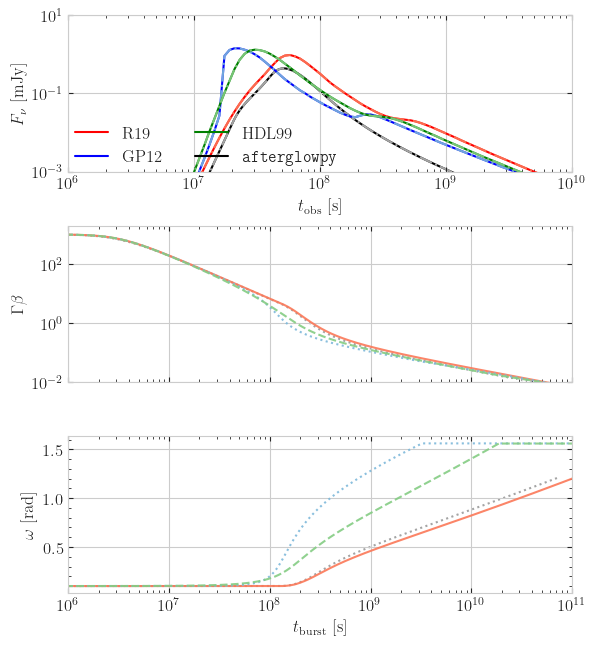

In [6]:
# Plot Spreading against afterglowpy (with n_ism=0.01)
def paper_plot_compare_spreading():

    struct=copy.deepcopy(tsk.structure)
    pars=copy.deepcopy(tsk.pars)
    opts_a=copy.deepcopy(tsk.opts_a)
    
    fig, axes = plt.subplots(figsize=(6,6.5), ncols=1, nrows=3)
    
    pars["n_ism"] = 1e-2
    pars["theta_obs"] = 0.785 

    cases.paper_plot_compare_spreading(axes, 
                                       struct=struct, pars=pars, opts_a=opts_a, 
                                       ref_lc_fname="reference_lc_0785deg_layer.h5", 
                                       ref_dyn_fname="reference_afgpy_dyn.h5")
    clear_output(wait=False)
    
    # plot
    ax = axes[0]
    # ax.grid()
    ax.legend(fancybox=True, loc='lower left',
              # bbox_to_anchor=(0.5, 0.5),  # loc=(0.0, 0.6),  # (1.0, 0.3), # <-> |
              shadow=False, ncol=2, fontsize=12,
              framealpha=0., borderaxespad=0.)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(r"$F_{\nu}$ [mJy]", fontsize=12)
    ax.set_xlabel(r"$t_{\rm obs}$ [s]", fontsize=12)
    # ax.set_title(title)
    ax.set_xlim(1e6,1e10)
    ax.set_ylim(1e-3,1e1)
    # ax.grid()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', labelleft=True,
                   labelright=False, tick1On=True, tick2On=True,
                   labelsize=12,
                   direction='in',
                   bottom=True, top=True, left=True, right=True)
    # ax.set_facecolor("pink")

    ax = axes[1]
    # ax.grid()
    # ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(r"$\Gamma\beta$", fontsize=12)
    ax.set_xlim(1e6,1e11)
    ax.set_ylim(1e-2,2e3)
    ax.tick_params(axis='both', which='both', labelleft=True,
                   labelright=False, tick1On=True, tick2On=True,
                   labelsize=12,
                   direction='in',
                   bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.minorticks_on()
    # ax.set_facecolor("pink")

    ax = axes[2]
    # ax.grid()
    # ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("linear")
    ax.set_ylabel(r"$\omega$ [rad]", fontsize=12)
    ax.set_xlabel(r"$t_{\rm burst}$ [s]", fontsize=12)
    ax.set_xlim(1e6,1e11)
    ax.tick_params(axis='both', which='both', labelleft=True,
                   labelright=False, tick1On=True, tick2On=True,
                   labelsize=12,
                   direction='in',
                   bottom=True, top=True, left=True, right=True)
    ax.minorticks_on()
    # ax.set_facecolor("pink")

    plt.tight_layout()

    figname = "abstract_tophat_spread_methods_lcs_dyn"
    plt.savefig(pdfs+figname+".pdf")
    plt.savefig(pdfs+figname+".png", dpi=256)
    plt.show()
paper_plot_compare_spreading()

# SkyMap

[ INFO    ] : [ main.cpp:152 ] : Computation tgrid = [3335.64, 9.7168e+15] n=1000
[ INFO    ] : [ main.cpp:153 ] : Output      tgrid = [3335.64, 9.7168e+15] n=1000
[ INFO    ] : [ model_magnetar.h:569 ] : Magnetar is not initialized and will not be considered.
[ INFO    ] : [ ejecta_id.h:206 ] :  1D ID has theta_wing=0.1 theta_core=0.1
[ INFO    ] : [ ejecta_id.h:258 ] : Initial data loaded with nshells=1 m_nlayers=50
[ INFO    ] : [ ejecta_id.h:280 ] : Angular grids are initialized. nshells=1 m_nlayers=50
[ INFO    ] : [ ejecta_id.h:303 ] : Energy and mass are rescaled.
[ WARNING ] : [ blastwave_base.h:104 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [ blastwave_base.h:107 ] : Parameter epsilon_e_rad not given. Using default value=0
[ WARNING ] : [ blastwave_radiation.h:808 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [ blastwave_radiation.h:815 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [ e

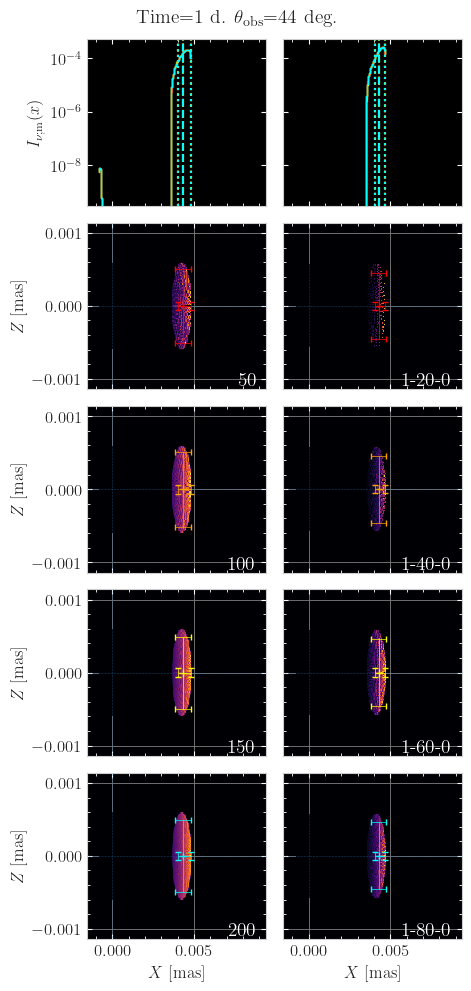

------------------------------------------------
time=10.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t10d


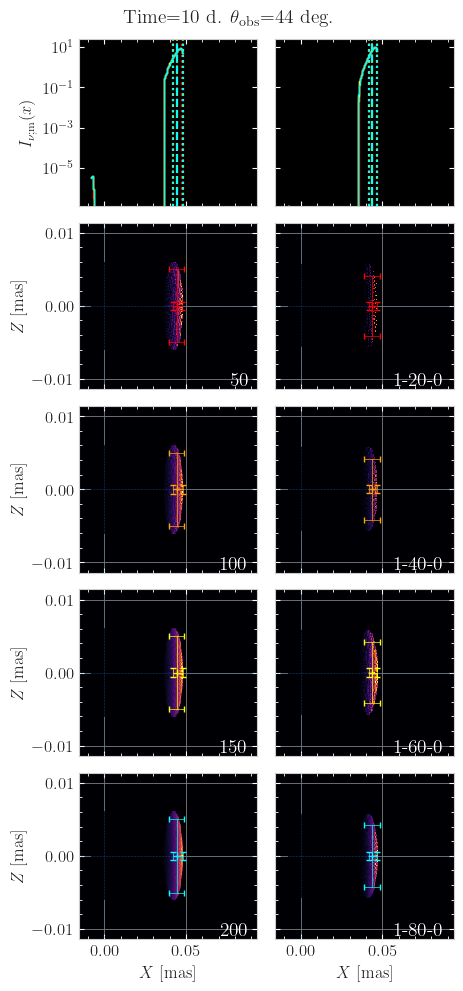

------------------------------------------------
time=40.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t40d


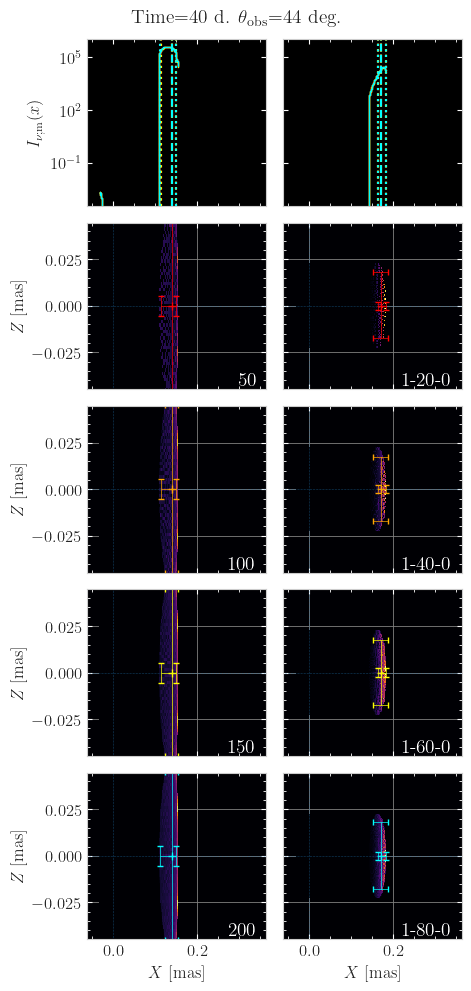

------------------------------------------------
time=100.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t100d


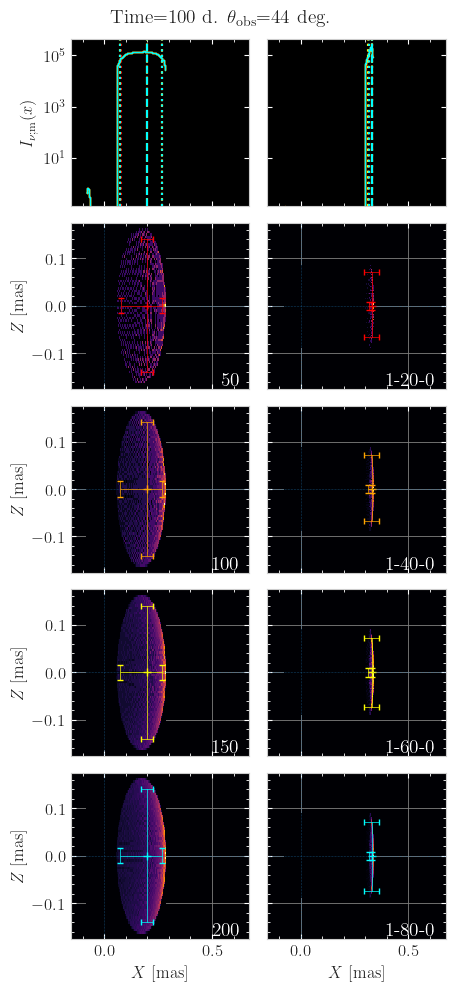

------------------------------------------------
time=200.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t200d


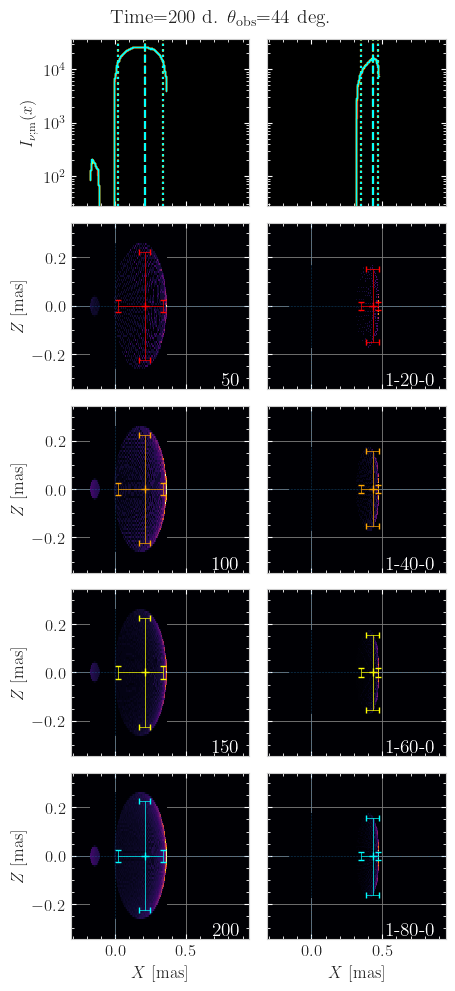

------------------------------------------------
time=300.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t300d


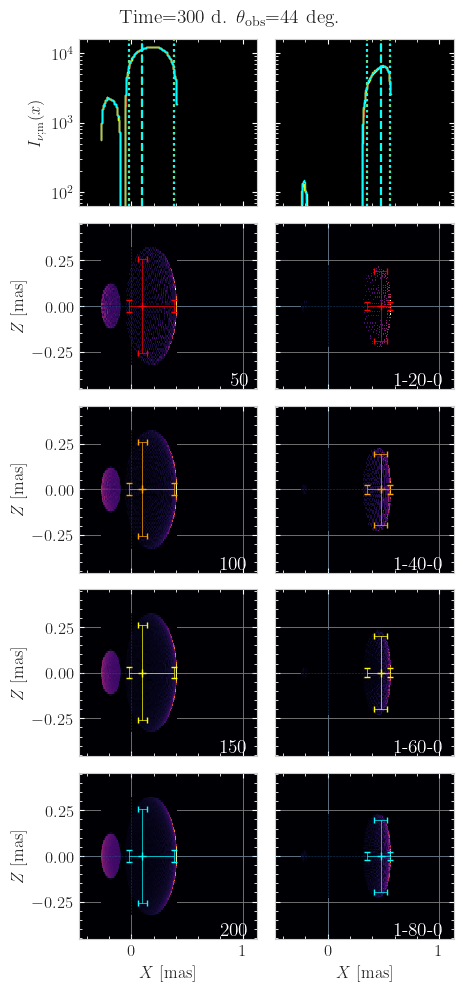

------------------------------------------------
time=400.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t400d


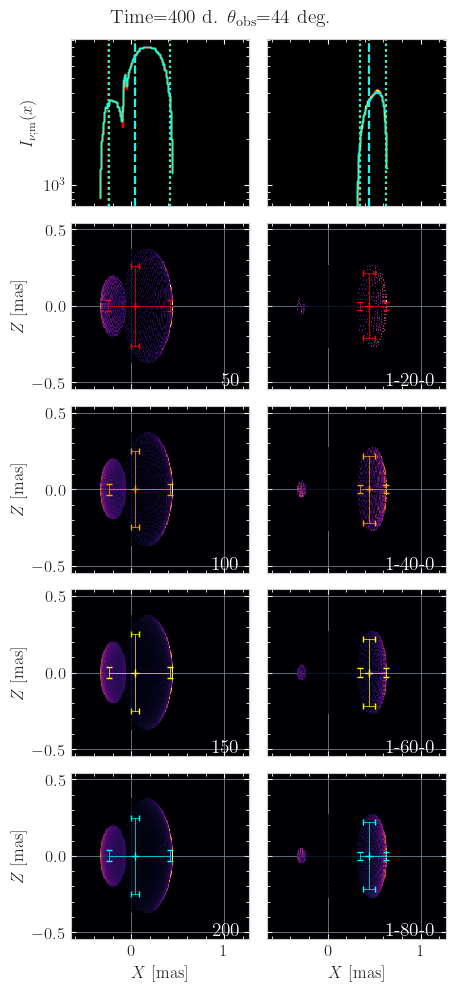

------------------------------------------------
time=600.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t600d


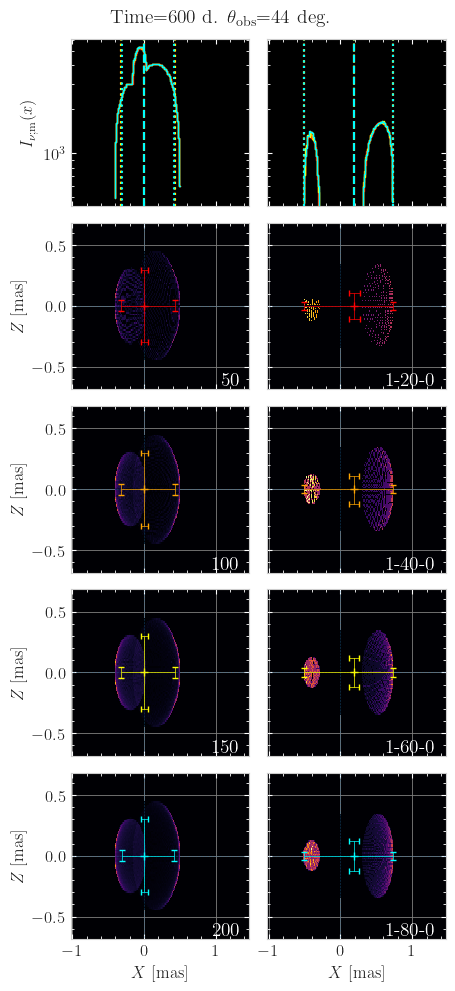

------------------------------------------------
time=800.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t800d


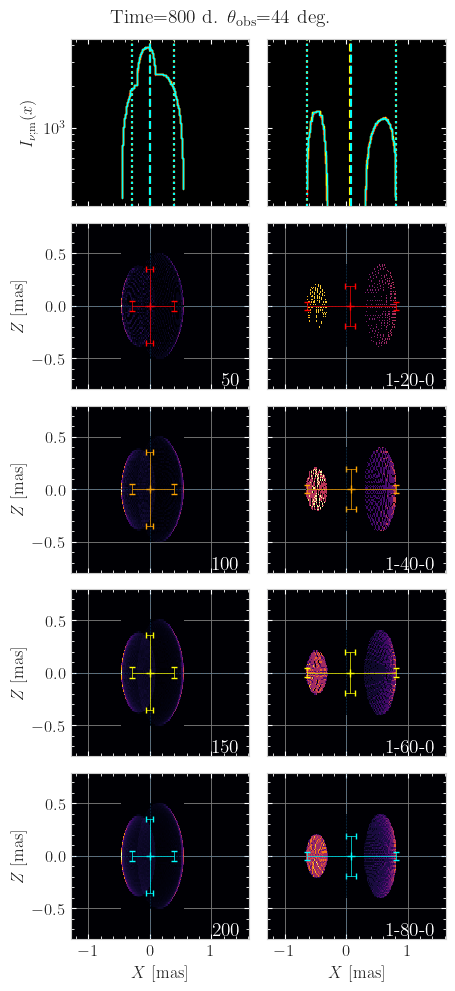

------------------------------------------------
time=1000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t1000d


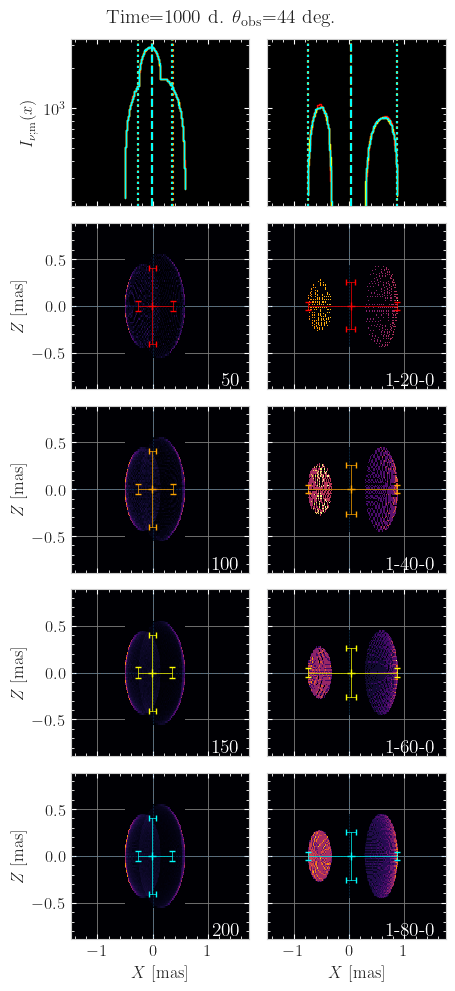

------------------------------------------------
time=1300.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t1300d


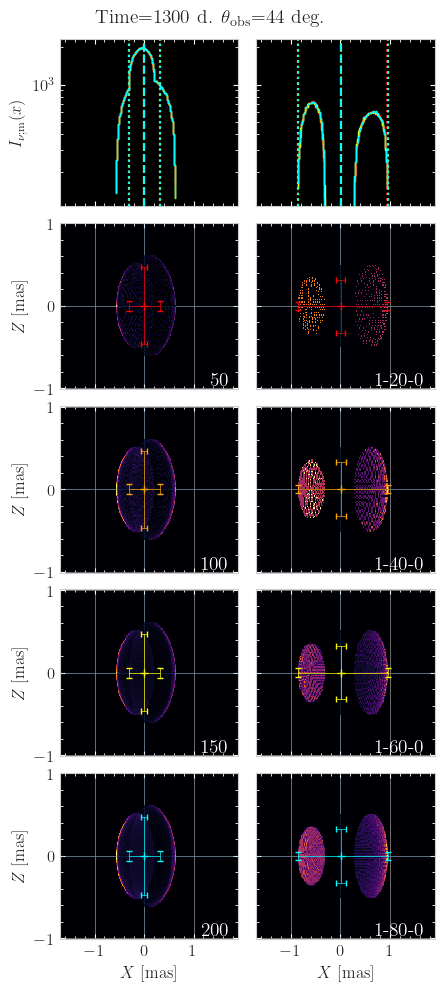

------------------------------------------------
time=1600.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t1600d


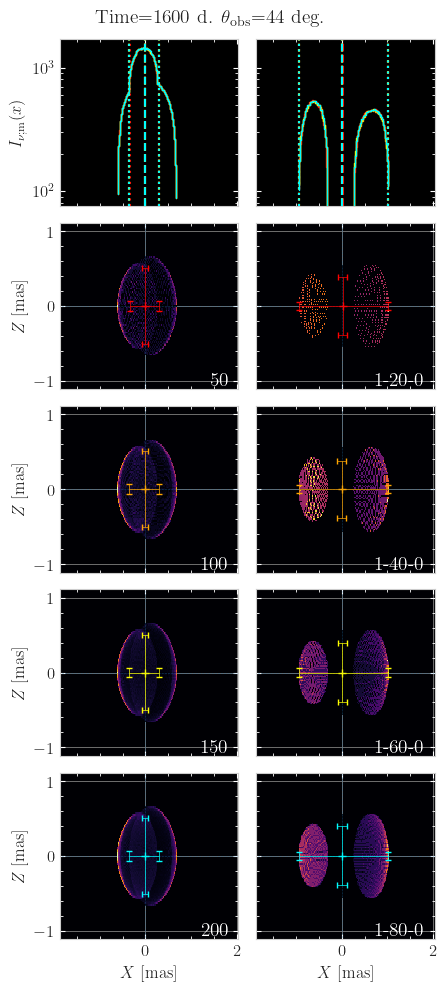

------------------------------------------------
time=2000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t2000d


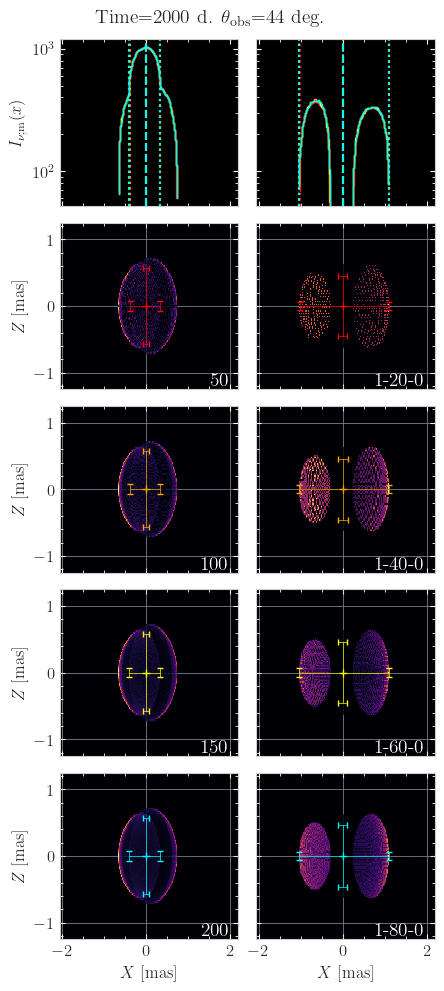

------------------------------------------------
time=2500.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t2500d


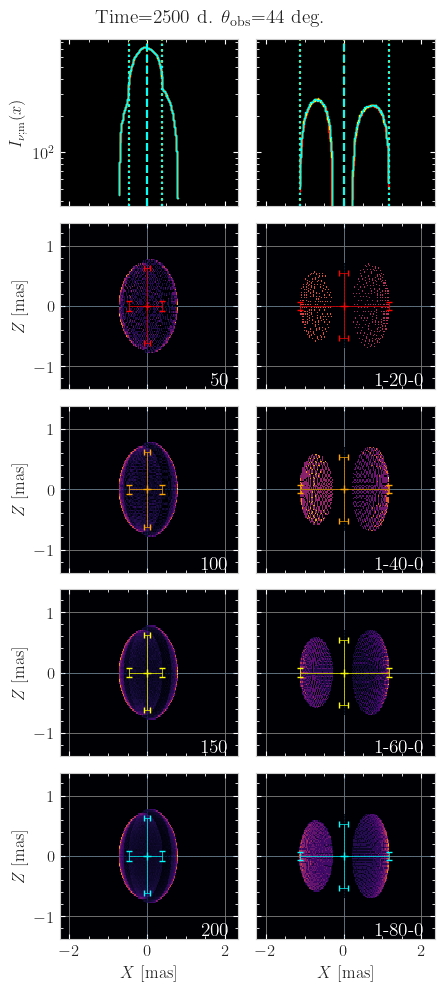

------------------------------------------------
time=3000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t3000d


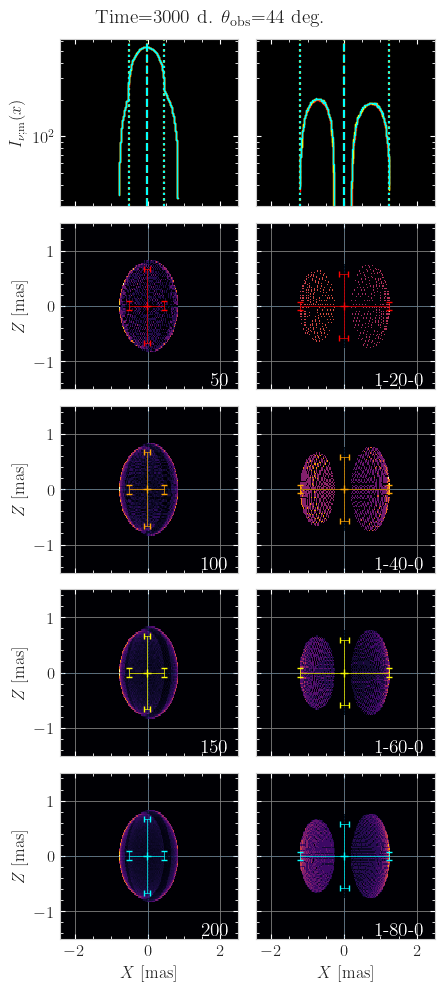

------------------------------------------------
time=4000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t4000d


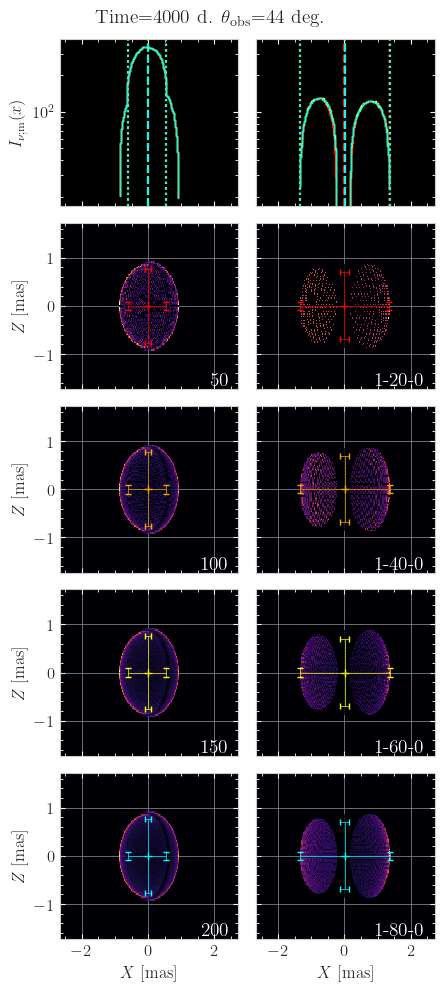

------------------------------------------------
time=5000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t5000d


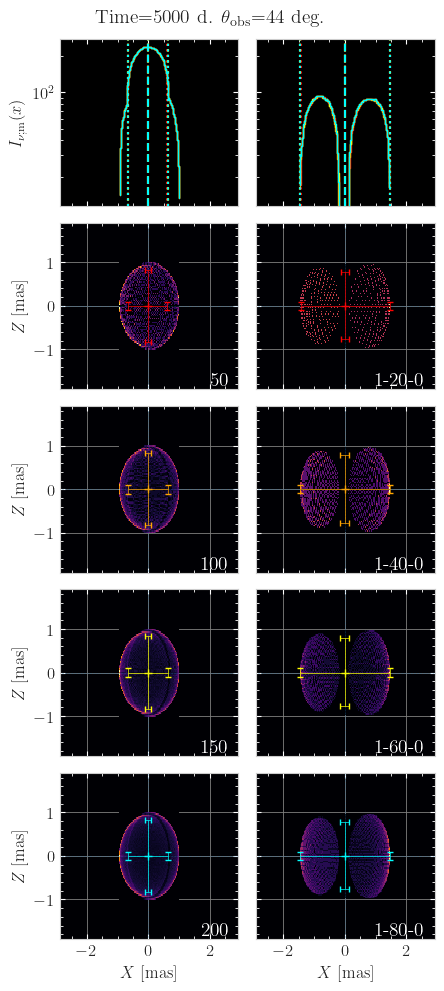

------------------------------------------------
time=7000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t7000d


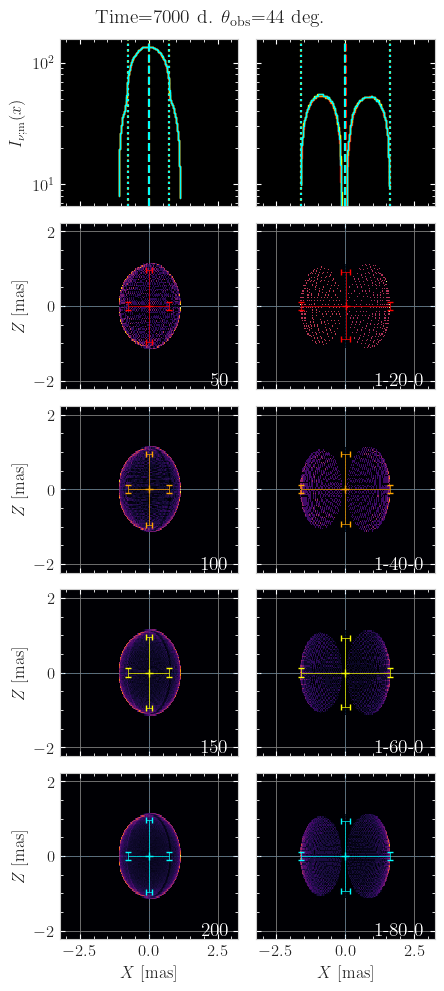

------------------------------------------------
time=10000.0
Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_res_t10000d


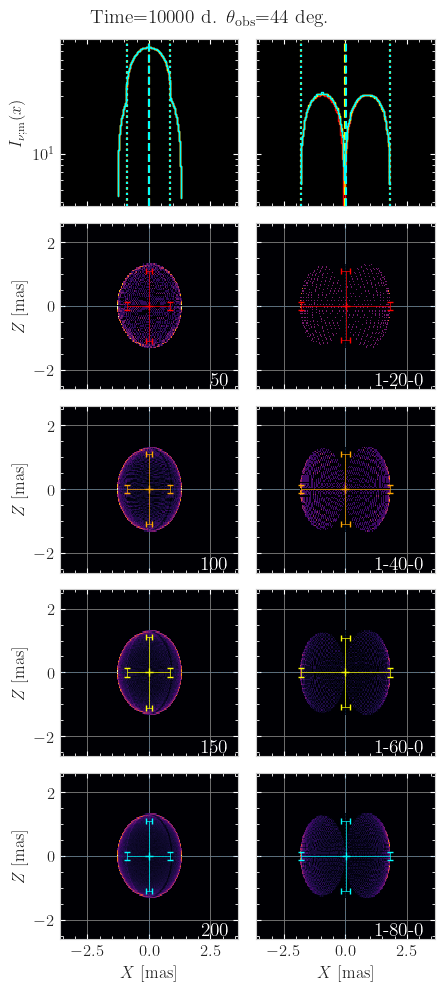

Saving:
 /home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat/figs/abstract_skymap_tophat_spread_45deg_propres


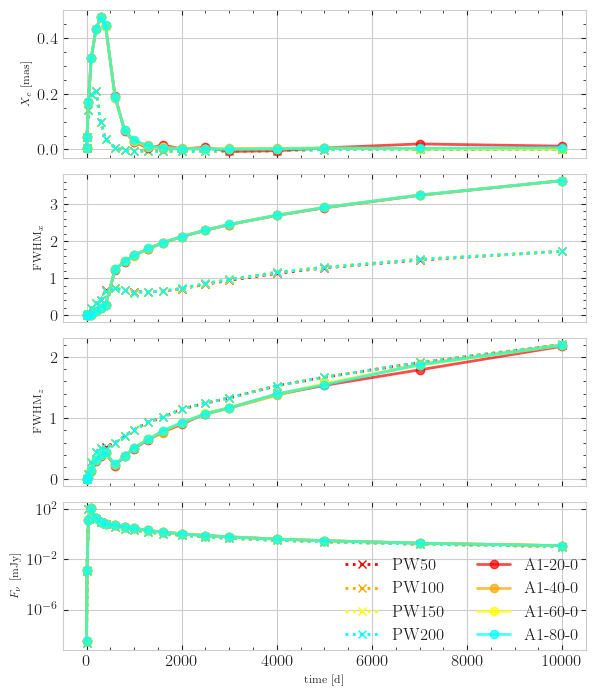

In [7]:
# plot one skymap as an example
tsk.opts_a["method_spread"] = "AFGPY"
tsk.opts_pw["method_spread"] = "AA"
tsk.pars["theta_obs"] = 0.785
cases.compare_skymap_evolution_plot_each_timestep(
    struct=tsk.structure, pars=tsk.pars, opts_a=tsk.opts_a, opts_pw=tsk.opts_pw, title=tsk.name_1,
    resolutions_pw=tsk.resolutions_pw, resolutions_a=tsk.resolutions_a,
    figfpath_skymap=figs+f"abstract_skymap_{tsk.figname}_spread_45deg_res",
    figfpath_evolve=figs+f"abstract_skymap_{tsk.figname}_spread_45deg_propres",
    fpath_out=curdir+"output/" + f"abstract_skymap_{tsk.figname}_spread_45deg_propres",
    plots=("xc","xsize","ysize","fluxes"),show_fig=True,save_pdf=False,save_res=False
)

In [ ]:
# Launch analysis for 3 angles * three spreading methods
runset_for_skymap(SettingsTopHat(),
                  default_parfile_fpath=curdir+"parfile_def.par",
                  workingdir=curdir+"output/",
                  figdir=figs+"skymaps/") # SKYMAP